<a href="https://colab.research.google.com/github/chrishg23-jpg/HES-benchmark/blob/main/Particles007.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2381857592.py:55: RuntimeWarning: invalid value encountered in divide
  particle.velocity += 0.02 * direction / np.linalg.norm(direction)
/tmp/ipython-input-2381857592.py:17: RuntimeWarning: invalid value encountered in cast
  x, y, z = pos.astype(int)


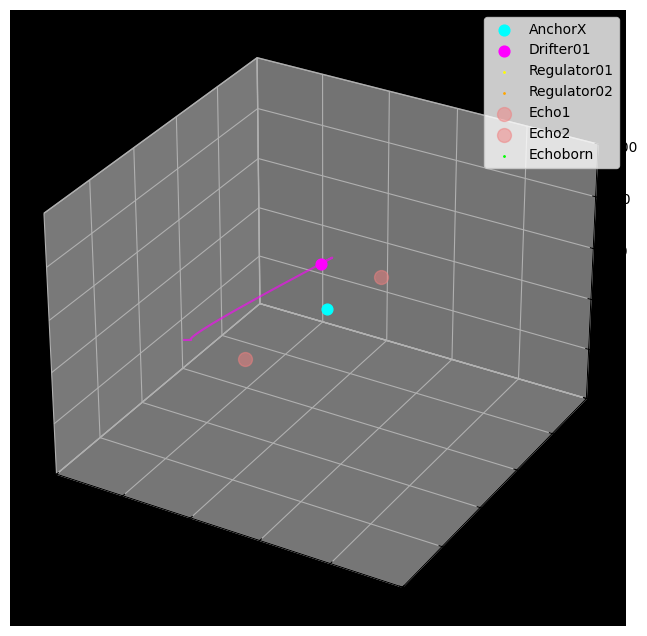

In [ ]:
# 📦 Imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

# 🧠 Memory field setup
memory_field = np.zeros((100, 100, 100))

def update_memory_field(echoes):
    for echo in echoes:
        x, y, z = echo["location"].astype(int)
        memory_field[x, y, z] += 1

def get_local_memory_density(pos):
    x, y, z = pos.astype(int)
    x, y, z = np.clip([x, y, z], 0, 99)
    return memory_field[x, y, z]

# 🧬 Particle class
class Particle:
    def __init__(self, id, position, velocity, color):
        self.id = id
        self.position = np.array(position, dtype=float)
        self.velocity = np.array(velocity, dtype=float)
        self.color = color
        self.trail = [self.position.copy()]
        self.memory = []

particles = {
    "AnchorX": Particle("AnchorX", [50, 50, 50], [0, 0, 0], "cyan"),
    "Drifter01": Particle("Drifter01", [20, 30, 40], [0.6, 0.2, 0.1], "magenta"),
    "Regulator01": Particle("Regulator01", [35, 35, 35], [0, 0, 0], "yellow"),
    "Regulator02": Particle("Regulator02", [60, 60, 60], [0, 0, 0], "orange")
}

collapse_echoes = []
echoborn = None
regulator_active = {"Regulator01": True, "Regulator02": True}
regulator_decay = {"Regulator01": 20, "Regulator02": 30}

# ⚖️ Law drift logic
def apply_law_drift(particle):
    density = get_local_memory_density(particle.position)
    drift = 0.05 * density
    particle.velocity += np.random.uniform(-drift, drift, size=3)

# 🎶 Emergent coordination logic
def apply_resonance(particle):
    for echo in collapse_echoes:
        dist = np.linalg.norm(particle.position - echo["location"])
        if dist < 25:
            direction = echo["location"] - particle.position
            particle.velocity += 0.02 * direction / np.linalg.norm(direction)

def synchronize_memory(p1, p2):
    shared = [e for e in p1.memory if e in p2.memory]
    if shared:
        p2.velocity += 0.05 * (p1.velocity - p2.velocity)

# 🌀 Collapse logic
def check_collapse():
    drifter = particles["Drifter01"]
    for reg_id in ["Regulator01", "Regulator02"]:
        regulator = particles[reg_id]
        if not regulator_active[reg_id]:
            continue
        dist = np.linalg.norm(drifter.position - regulator.position)
        if dist < 15:
            drifter.velocity *= -0.5
            regulator_active[reg_id] = False
            echo = {
                "location": regulator.position.copy(),
                "triggered_by": "Drifter01"
            }
            collapse_echoes.append(echo)
            drifter.memory.append(echo)
            update_memory_field([echo])

# 🧠 Echo response
def respond_to_echoes():
    drifter = particles["Drifter01"]
    for echo in collapse_echoes:
        dist = np.linalg.norm(drifter.position - echo["location"])
        if dist < 20:
            drifter.velocity += 0.1

# 🌱 Spawn Echoborn
def spawn_echoborn():
    global echoborn
    if collapse_echoes and echoborn is None:
        loc = collapse_echoes[0]["location"]
        echoborn = Particle("Echoborn", loc, [0.2, -0.1, 0.3], "lime")

# 📍 Anchor harmonics
def pulse_anchor():
    anchor = particles["AnchorX"]
    echo_count = len(collapse_echoes)
    pulse = 0.02 * echo_count
    anchor.position += np.random.uniform(-pulse, pulse, size=3)

# 🎥 Animation setup
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.set_facecolor('black')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.set_zlim(0, 100)

    # Regulator decay
    for reg_id in regulator_decay:
        if regulator_active[reg_id]:
            regulator_decay[reg_id] -= 1
            if regulator_decay[reg_id] <= 0:
                regulator_active[reg_id] = False

    # Update particles
    for p in particles.values():
        apply_law_drift(p)
        apply_resonance(p)
        p.position += p.velocity
        p.trail.append(p.position.copy())

    check_collapse()
    respond_to_echoes()
    spawn_echoborn()
    pulse_anchor()

    # Synchronize memory
    if echoborn:
        synchronize_memory(particles["Drifter01"], echoborn)

    # Plot particles and trails
    for p in particles.values():
        x, y, z = p.position
        ax.scatter(x, y, z, color=p.color, s=60, label=p.id)
        trail = np.array(p.trail)
        if len(trail) > 1:
            ax.plot(trail[:,0], trail[:,1], trail[:,2], color=p.color, alpha=0.6)

    # Plot echoes
    for i, echo in enumerate(collapse_echoes):
        x, y, z = echo["location"]
        ax.scatter(x, y, z, color='lightcoral', s=100, alpha=0.5, label=f"Echo{i+1}")

    # Plot Echoborn
    if echoborn:
        apply_law_drift(echoborn)
        apply_resonance(echoborn)
        echoborn.position += echoborn.velocity
        echoborn.trail.append(echoborn.position.copy())
        x, y, z = echoborn.position
        ax.scatter(x, y, z, color=echoborn.color, s=80, label="Echoborn")
        trail = np.array(echoborn.trail)
        if len(trail) > 1:
            ax.plot(trail[:,0], trail[:,1], trail[:,2], color=echoborn.color, alpha=0.6)

    ax.legend(loc='upper right')

# 🎬 Save and display animation
anim = FuncAnimation(fig, update, frames=30, interval=500)
HTML(anim.to_html5_video())
